In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
)
data = pd.read_csv('Predict_Academic_Success_Modified.csv')

In [28]:
# convert the target using Label Encoding ('Dropout', 'Enrolled', 'Graduate')
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"]) 

In [29]:
# 90% for training/testing, 10% for unseen validation
train_test_data, unseen_data = train_test_split(data, test_size=0.10, random_state=42, stratify=data["Target"])

In [30]:
# For training data
# Get the target and feature of the training/testing data 
X = train_test_data.drop(columns=["Target"]) # Features
y = train_test_data["Target"] # Target

In [31]:
# encode categorical features
categorical_cols = ["Previous qualification", "Mother's qualification", "Father's qualification", "Nacionality",
                    "Mother's occupation", "Father's occupation", "Marital status", "Application mode",
                    "Course", "Daytime/evening attendance", "Displaced", "Educational special needs", 
                    "Debtor", "Tuition fees up to date", "Gender", "Scholarship holder", "International"]

for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])  

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [32]:
# Split the data into training and test sets  80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Train the model which insert the training data from the feature and the target
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [34]:
#apply 10 fold cross validation testing
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring="accuracy")
# Make a prediction
y_pred = knn.predict(X_test)


Testing Data Evaluation Results



,Metric,Value
0,Cross-Validation Accuracy,0.699434
1,Accuracy,0.715182
2,Precision,0.705938
3,Recall,0.715182
4,ROC-AUC Score,0.805146


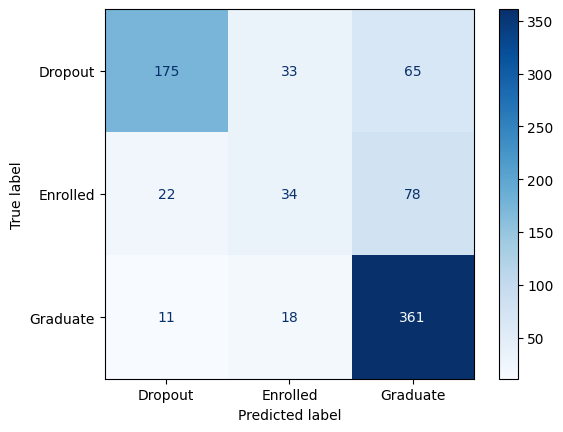

In [35]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test), multi_class="ovr")
conf_matrix = confusion_matrix(y_test, y_pred)
# Disctionary for displatyng the result in tabular form
testing_metrics = {
    "Metric": [
        "Cross-Validation Accuracy",
        "Accuracy",
        "Precision",
        "Recall",
        "ROC-AUC Score"
    ],
    "Value": [
        np.mean(cv_scores),
        accuracy,
        precision,
        recall,
        roc_auc
    ]
}
df_testing_metrics = pd.DataFrame(testing_metrics)


# Display Confusion Matrix of testing data
class_names = ['Dropout', 'Enrolled', 'Graduate']
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=class_names, cmap=plt.cm.Blues
)

# Display the results for testing data
print("\nTesting Data Evaluation Results\n")
df_testing_metrics

In [36]:
#For unseen data
# Get the target and feature of the training/testing data 
X_unseen = unseen_data.drop(columns=["Target"]) # Features
y_unseen = unseen_data["Target"] # Target

In [37]:
# encode categorical features
for col in categorical_cols:
    X_unseen[col] = LabelEncoder().fit_transform(X_unseen[col])  

X_unseen = pd.DataFrame(scaler.fit_transform(X_unseen), columns=X_unseen.columns)

In [38]:
#apply 10 fold cross validation
unseen_cv_scores = cross_val_score(knn, X_unseen, y_unseen, cv=kf, scoring="accuracy")
# Make a prediction
y_unseen_pred = knn.predict(X_unseen)
y_unseen_predict_labels = label_encoder.inverse_transform(y_unseen_pred)
unseen_knn = pd.DataFrame({"Actual": label_encoder.inverse_transform(y_unseen), "Predicted": y_unseen_predict_labels})
unseen_knn.to_csv("knn-predic.csv", index=False)


Unseen Data Evaluation Results



,Metric,Value
0,Cross-Validation Accuracy,0.668434
1,Accuracy,0.713318
2,Precision,0.714532
3,Recall,0.713318
4,ROC-AUC Score,0.829846


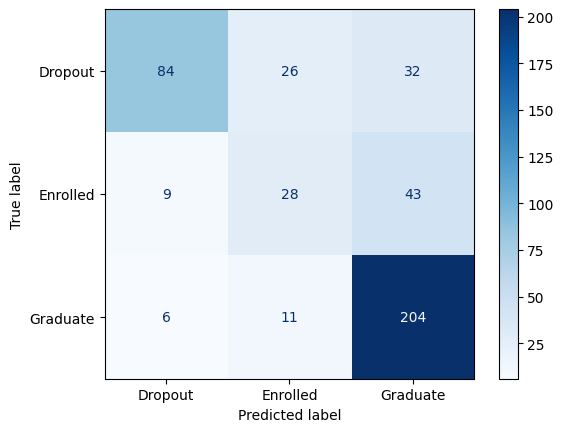

In [39]:
# Evaluation Metrics
unseen_accuracy = accuracy_score(y_unseen, y_unseen_pred)
unseen_precision = precision_score(y_unseen, y_unseen_pred, average='weighted')
unseen_recall = recall_score(y_unseen, y_unseen_pred, average='weighted')
unseen_roc_auc = roc_auc_score(y_unseen, knn.predict_proba(X_unseen), multi_class="ovr")
unseen_conf_matrix = confusion_matrix(y_unseen, y_unseen_pred)

# Dictionary for display the result in tabular form
unseen_metrics = {
    "Metric": [
        "Cross-Validation Accuracy",
        "Accuracy",
        "Precision",
        "Recall",
        "ROC-AUC Score"
    ],
    "Value": [
        np.mean(unseen_cv_scores),
        unseen_accuracy,
        unseen_precision,
        unseen_recall,
        unseen_roc_auc
    ]
}
# Display Confusion Matrix  of unseen data
df_unseen_metrics = pd.DataFrame(unseen_metrics)
disp = ConfusionMatrixDisplay.from_predictions(
    y_unseen, y_unseen_pred, display_labels=class_names, cmap=plt.cm.Blues
)

# Display the results for unseen data
print("\nUnseen Data Evaluation Results\n")
df_unseen_metrics



In [5]:
import pandas as pd

df = pd.read_csv('knn-predic.csv')

# Count matches and mismatches for each class
matches = df[df["Actual"] == df["Predicted"]]["Actual"].value_counts()
mismatches = df[df["Actual"] != df["Predicted"]]["Actual"].value_counts()

freq_table = pd.DataFrame({
    "Category": ["Graduate", "Enrolled", "Dropout"],
    "Matches": [matches.get("Graduate", 0), matches.get("Enrolled", 0), matches.get("Dropout", 0)],
    "Mismatches": [mismatches.get("Graduate", 0), mismatches.get("Enrolled", 0), mismatches.get("Dropout", 0)]
})

# Display the frequency table
freq_table

,Category,Matches,Mismatches
0,Graduate,204,17
1,Enrolled,28,52
2,Dropout,84,58
